# 1. Download and prepare RGB stars catalogue

In [1]:
import os
import pathlib
import requests
from zipfile import ZipFile
from tqdm import tqdm

import numpy as np
import scipy as sp
import pandas as pd

import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactocentric
from astropy_healpix import HEALPix
import dustmaps
import dustmaps.config
import dustmaps.gaia_tge

import config
import utils

hpx_order=7 --> (hpx_nside=128, hpx_npix=196608)


In [2]:
cache_path = pathlib.Path(config.cache_path)
cache_path.mkdir(exist_ok=True)

fig_path = pathlib.Path(config.fig_path)
fig_path.mkdir(exist_ok=True)

## Download Andrae et al. (2023) vetted sample of RGB stars

Paper: https://ui.adsabs.harvard.edu/abs/2023ApJS..267....8A

Data: https://zenodo.org/records/7945154

In [3]:
# Download the Andrae et al. (2023) vetted sample of RGB stars

url = 'https://zenodo.org/records/7945154/files/table_2_catwise.csv.gz?download=1'
file_name = cache_path / 'Andrae2023_table_2_catwise.csv.gz'
utils.download_file(url, file_name)

Starting download from https://zenodo.org/records/7945154/files/table_2_catwise.csv.gz?download=1
File 'cache/Andrae2023_table_2_catwise.csv.gz' already downloaded
Done


In [4]:
# Read in the downloaded catalogue
# Use only necessary columns
usecols = ['source_id', 'ra', 'dec', 'l', 'b', 'parallax', 'parallax_error', \
           'pmra', 'pmdec', 'radial_velocity', \
           'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', \
           'mh_xgboost', 'teff_xgboost', 'logg_xgboost']
rgb = pd.read_csv(file_name, usecols=usecols)
print("Num. of RGB stars:", len(rgb))

Num. of RGB stars: 17558141


## Estimate extinctions in Gaia bands

### Load dustmap

Manual: https://dustmaps.readthedocs.io/en/latest/

See also https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_astrophysical_parameter_tables/ssec_dm_total_galactic_extinction_map.html#total_galactic_extinction_map-a0

In [5]:
dustmaps.config.config['data_dir'] = str(cache_path / 'dustmaps.data')
dustmaps.gaia_tge.fetch()
dm = dustmaps.gaia_tge.GaiaTGEQuery(healpix_level=config.hpx_order)

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


### Estimate A_0 for every star

A_0 is the monochromatic extinction at 541.4 nm ([Fitzpatrick 1999](https://iopscience.iop.org/article/10.1086/316293); [Delchambre et al. 2023](http://dx.doi.org/10.1051/0004-6361/202243423))

In [6]:
l = rgb['l'].values
b = rgb['b'].values
co = SkyCoord(l, b, frame='galactic', unit='deg')

rgb['a0'] = dm.query(co)
print("NaNs in A0:", rgb['a0'].isnull().sum())

NaNs in A0: 1851610


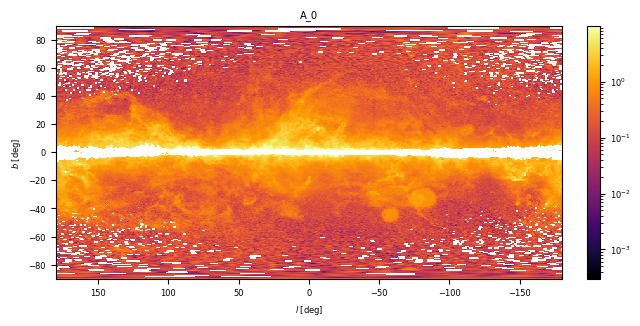

In [7]:
# Plot the extinction map on the sky

hp = HEALPix(nside=config.hpx_nside, order='nested', frame='galactic')
co = hp.healpix_to_skycoord(range(config.hpx_npix))
a0_map = dm.query(co)

plt.rc('font', size=6.0)
inch = 2.54  # cm
width, height = 16/inch, 8/inch
plt.figure(figsize=(width, height), layout='constrained')

utils.plot_hpxmap(a0_map, title="A_0")

plt.savefig(fig_path / 'a0_map.pdf', dpi=config.pdf_dpi)
plt.show()
plt.close()

### Estimate A_G, A_BP, and A_RP for every star

Use the [Fitzpatrick et al. (2019)](https://iopscience.iop.org/article/10.3847/1538-4357/ab4c3a) 3rd-order polynomial approximation

Data: https://www.cosmos.esa.int/web/gaia/edr3-extinction-law

In [8]:
# Download the Fitzpatrick et al. (2019) extinctions approximation table

url = 'https://www.cosmos.esa.int/documents/29201/1658422/Fitz19_EDR3_extinctionlawcoefficients.zip'
file_name = cache_path / 'Fitz19_EDR3_extinctionlawcoefficients.zip'
utils.download_file(url, file_name)

Starting download from https://www.cosmos.esa.int/documents/29201/1658422/Fitz19_EDR3_extinctionlawcoefficients.zip
File 'cache/Fitz19_EDR3_extinctionlawcoefficients.zip' already downloaded
Done


In [9]:
with ZipFile(file_name, 'r') as zf:
    with zf.open('Fitz19_EDR3_HRDTop.csv') as f:
        fitz0 = pd.read_csv(f)
#fitz0

In [10]:
# See https://www.cosmos.esa.int/web/gaia/edr3-extinction-law
# km = a1 + a2*X + a3*X^2 + a4*X^3 + a5*A0 + a6*A0^2 + a7*A0^3 + a8*A0*X + a9*A0*X^2 + a10*X*A0*2

a0 = rgb['a0']
Teff_0 = 5040.0  # K
teffnorm = rgb['teff_xgboost'] / Teff_0

mask = (fitz0['Xname'] == 'TeffNorm') & (fitz0['Kname'] == 'kG')
fitz = fitz0[mask].to_dict(orient='records')[0]
kG = fitz['Intercept'] + fitz['X']*teffnorm + fitz['X2']*teffnorm**2 + fitz['X3']*teffnorm**3 \
     + fitz['A']*a0 + fitz['A2']*a0**2 + fitz['A3']*a0**3 \
     + fitz['XA']*a0*teffnorm + fitz['AX2']*a0*teffnorm**2 + fitz['XA2']*a0**2*teffnorm
rgb['ag'] = kG * a0

mask = (fitz0['Xname'] == 'TeffNorm') & (fitz0['Kname'] == 'kBP')
fitz = fitz0[mask].to_dict(orient='records')[0]
kBP = fitz['Intercept'] + fitz['X']*teffnorm + fitz['X2']*teffnorm**2 + fitz['X3']*teffnorm**3 \
      + fitz['A']*a0 + fitz['A2']*a0**2 + fitz['A3']*a0**3 \
      + fitz['XA']*a0*teffnorm + fitz['AX2']*a0*teffnorm**2 + fitz['XA2']*a0**2*teffnorm
rgb['abp'] = kBP * a0

mask = (fitz0['Xname'] == 'TeffNorm') & (fitz0['Kname'] == 'kRP')
fitz = fitz0[mask].to_dict(orient='records')[0]
kRP = fitz['Intercept'] + fitz['X']*teffnorm + fitz['X2']*teffnorm**2 + fitz['X3']*teffnorm**3 \
      + fitz['A']*a0 + fitz['A2']*a0**2 + fitz['A3']*a0**3 \
      + fitz['XA']*a0*teffnorm + fitz['AX2']*a0*teffnorm**2 + fitz['XA2']*a0**2*teffnorm
rgb['arp'] = kRP * a0

Stars with A_0: 15706531


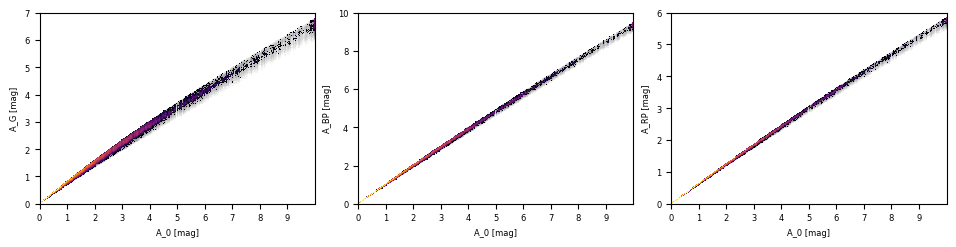

In [11]:
# Select the stars that have A_0
mask = rgb['a0'].isna()
rgb_a0 = rgb.loc[~mask,:].copy()
print(f"Stars with A_0: {len(rgb_a0)}")


plt.rc('font', size=6.0)
inch = 2.54  # cm
width, height = 24/inch, 6/inch
plt.figure(figsize=(width, height), layout='constrained')

norm = 'log'

# Select low-metallicity stars
mask = (-3.0 <= rgb_a0['mh_xgboost']) & (rgb_a0['mh_xgboost'] <= -1.0)
rgb_a0_lome = rgb_a0[mask]

plt.subplot(1, 3, 1)
plt.hist2d(rgb_a0['a0'], rgb_a0['ag'], bins=300, cmap='Greys', norm=norm, rasterized=True)
plt.hist2d(rgb_a0_lome['a0'], rgb_a0_lome['ag'], bins=300, cmap='inferno', norm=norm, rasterized=True)
plt.xlabel("A_0 [mag]")
plt.xticks(np.linspace(0.0, 9.0, 10))
plt.ylabel("A_G [mag]")
plt.ylim(0.0, 7.0)

plt.subplot(1, 3, 2)
plt.hist2d(rgb_a0['a0'], rgb_a0['abp'], bins=300, cmap='Greys', norm=norm, rasterized=True)
plt.hist2d(rgb_a0_lome['a0'], rgb_a0_lome['abp'], bins=300, cmap='inferno', norm=norm, rasterized=True)
plt.xlabel("A_0 [mag]")
plt.xticks(np.linspace(0.0, 9.0, 10))
plt.ylabel("A_BP [mag]")
plt.ylim(0.0, 10.0)

plt.subplot(1, 3, 3)
plt.hist2d(rgb_a0['a0'], rgb_a0['arp'], bins=300, cmap='Greys', norm=norm, rasterized=True)
plt.hist2d(rgb_a0_lome['a0'], rgb_a0_lome['arp'], bins=300, cmap='inferno', norm=norm, rasterized=True)
plt.xlabel("A_0 [mag]")
plt.xticks(np.linspace(0.0, 9.0, 10))
plt.ylabel("A_RP [mag]")
plt.ylim(0.0, 6.0)

plt.show()
plt.savefig(fig_path / 'a0-am.pdf')
plt.close()

### Fit A_G(A_0) neglecting the T_eff dependence

In [12]:
def Am_fit(A0, c1, c2, c3, c4):
    return c1*A0 + c2*A0**2 + c3*A0**3 + c4*A0**4

# G
popt, _ = sp.optimize.curve_fit(Am_fit, rgb_a0['a0'], rgb_a0['ag'])
AG_fit_coef = list(popt)
print("AG_fit_coef: ", AG_fit_coef)

# BP
popt, _ = sp.optimize.curve_fit(Am_fit, rgb_a0['a0'], rgb_a0['abp'])
ABP_fit_coef = list(popt)
print("ABP_fit_coef:", ABP_fit_coef)

# RP
popt, _ = sp.optimize.curve_fit(Am_fit, rgb_a0['a0'], rgb_a0['arp'])
ARP_fit_coef = list(popt)
print("ARP_fit_coef:", ARP_fit_coef)

AG_fit_coef:  [0.8202675448004149, -0.033866129194463176, 0.002555660787363832, -8.131958543586709e-05]
ABP_fit_coef: [1.033958907987408, -0.02087730228623261, 0.0015881544018400127, -5.019377508885573e-05]
ARP_fit_coef: [0.6371221974165605, -0.009100437469083308, 0.0003998347218506803, -9.808820311772118e-06]


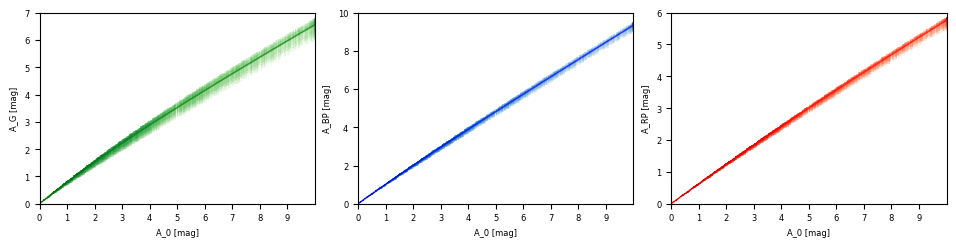

In [13]:
plt.rc('font', size=6.0)
inch = 2.54  # cm
width, height = 24/inch, 6/inch
plt.figure(figsize=(width, height), layout='constrained')

norm = 'log'
a0 = np.linspace(0.0, 10.0, 201)

plt.subplot(1, 3, 1)
plt.hist2d(rgb_a0['a0'], rgb_a0['ag'], bins=300, cmap='Greens', norm=norm, rasterized=True)
plt.plot(a0, Am_fit(a0, *AG_fit_coef), 'g', lw=1.2, alpha=0.7)
plt.xlabel("A_0 [mag]")
plt.xticks(np.linspace(0.0, 9.0, 10))
plt.ylabel("A_G [mag]")
plt.ylim(0.0, 7.0)

plt.subplot(1, 3, 2)
plt.hist2d(rgb_a0['a0'], rgb_a0['abp'], bins=300, cmap='Blues', norm=norm, rasterized=True)
plt.plot(a0, Am_fit(a0, *ABP_fit_coef), 'b', lw=1.2, alpha=0.7)
plt.xlabel("A_0 [mag]")
plt.xticks(np.linspace(0.0, 9.0, 10))
plt.ylabel("A_BP [mag]")
plt.ylim(0.0, 10.0)

plt.subplot(1, 3, 3)
plt.hist2d(rgb_a0['a0'], rgb_a0['arp'], bins=300, cmap='Reds', norm=norm, rasterized=True)
plt.plot(a0, Am_fit(a0, *ARP_fit_coef), 'r', lw=1.2, alpha=0.7)
plt.xlabel("A_0 [mag]")
plt.xticks(np.linspace(0.0, 9.0, 10))
plt.ylabel("A_RP [mag]")
plt.ylim(0.0, 6.0)

plt.show()
plt.savefig(fig_path / 'a0-am_fit.pdf')
plt.close()

### Calculate and save the A_G map

We will use it later.

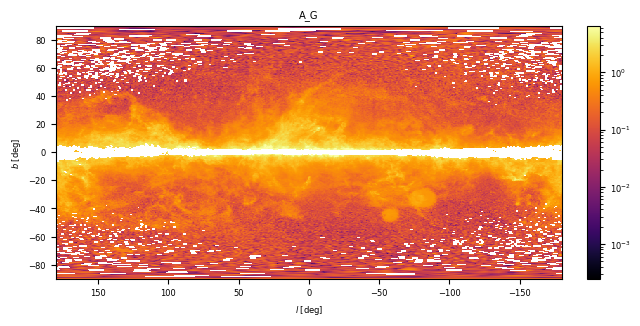

In [14]:
ag_map = Am_fit(a0_map, *AG_fit_coef)

plt.rc('font', size=6.0)
inch = 2.54  # cm
width, height = 16/inch, 8/inch
plt.figure(figsize=(width, height), layout='constrained')

utils.plot_hpxmap(ag_map, title="A_G")

plt.savefig(fig_path / 'ag_map.pdf', dpi=config.pdf_dpi)
plt.show()
plt.close()

In [15]:
d = {}
d['ag_map'] = ag_map
# Save as a compressed archive
np.savez_compressed(cache_path / 'ag_map.npz', **d)

In [16]:
## Don't need it anymore
del(dm, rgb_a0, rgb_a0_lome)

## Make the transformation from Galactic to Galactocentric frame

In [17]:
# Use inverse parallax as a distance measure
rgb['dist'] = 1 / rgb['parallax']

In [18]:
# The Galactocentric frame
gc_frame = Galactocentric()

# Use the default position and velocity of the Sun
# At the September 2024, the coordinates are taken from GRAVITY Collaboration et al. (2018) and Bennett & Bovy (2019);
# velocities are taken brom Drimmel & Poggio (2018), GRAVITY Collaboration et al. (2018), Reid & Brunthaler (2004)
c_sun_icrs = SkyCoord(0*u.deg, 0*u.deg, 0*u.kpc, pm_ra_cosdec=0*u.mas/u.yr, pm_dec=0*u.mas/u.yr, radial_velocity=0*u.km/u.s, frame='icrs')
c_sun_gc = c_sun_icrs.transform_to(gc_frame)

x_sun = c_sun_gc.x.value
y_sun = c_sun_gc.y.value
z_sun = c_sun_gc.z.value
print("Sun Cartesian pos:", x_sun, y_sun, z_sun)

vx_sun = c_sun_gc.v_x.value
vy_sun = c_sun_gc.v_y.value
vz_sun = c_sun_gc.v_z.value
print("Sun Cartesian vel:", vx_sun, vy_sun, vz_sun)

Sun Cartesian pos: -8.1219733661223 0.0 0.020800000000000003
Sun Cartesian vel: 12.899999999999999 245.6 7.779999999999999


In [19]:
# Clickable references:
astropy.coordinates.galactocentric_frame_defaults.get_from_registry('latest')

{'parameters': {'galcen_coord': <ICRS Coordinate: (ra, dec) in deg
      (266.4051, -28.936175)>,
  'galcen_distance': <Quantity 8.122 kpc>,
  'galcen_v_sun': <CartesianDifferential (d_x, d_y, d_z) in km / s
      (12.9, 245.6, 7.78)>,
  'z_sun': <Quantity 20.8 pc>,
  'roll': <Quantity 0. deg>},
 'references': {'galcen_coord': 'https://ui.adsabs.harvard.edu/abs/2004ApJ...616..872R',
  'galcen_distance': 'https://ui.adsabs.harvard.edu/abs/2018A%26A...615L..15G',
  'galcen_v_sun': ['https://ui.adsabs.harvard.edu/abs/2018RNAAS...2..210D',
   'https://ui.adsabs.harvard.edu/abs/2018A%26A...615L..15G',
   'https://ui.adsabs.harvard.edu/abs/2004ApJ...616..872R'],
  'z_sun': 'https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.1417B',
  'roll': None}}

In [20]:
# Another way to define the Galactic frame when we like someone's estimate for the Sun position and velocity
#gc_frame = Galactocentric(galcen_distance=abs(x_sun)*u.kpc, z_sun=z_sun*u.kpc, galcen_v_sun=[vx_sun, vy_sun, vz_sun]*u.km/u.s)

In [21]:
# Transfrom
# Actually we don't need velocities for our model but let them be

c_icrs = SkyCoord(rgb['ra'].values * u.deg,
                  rgb['dec'].values * u.deg,
                  rgb['dist'].values * u.kpc,
                  pm_ra_cosdec=rgb['pmra'].values * u.mas/u.yr,
                  pm_dec=rgb['pmdec'].values * u.mas/u.yr,
                  radial_velocity=rgb['radial_velocity'].values * u.km/u.s,
                  frame='icrs')

c_gc = c_icrs.transform_to(gc_frame)

x = c_gc.x.to(u.kpc).value
y = c_gc.y.to(u.kpc).value
z = c_gc.z.to(u.kpc).value

vx = c_gc.v_x.to(u.km/u.s).value
vy = c_gc.v_y.to(u.km/u.s).value
vz = c_gc.v_z.to(u.km/u.s).value

rgb['x'], rgb['y'], rgb['z']    =  x,  y,  z
rgb['vx'], rgb['vy'], rgb['vz'] = vx, vy, vz

## Save RGB stars catalogue

In [22]:
# We don't care of NaNs in velocities or extinctions
print("NaNs:")
print(rgb.isna().sum())

print("Columns:", rgb.columns)

# The HDF5 format is fast!
columns = ['source_id', 'l', 'b', 'parallax', 'parallax_error', 'dist', 'x', 'y', 'z', 'vx', 'vy', 'vz', \
           'phot_g_mean_mag', 'mh_xgboost']
rgb[columns].to_hdf(cache_path / 'rgb.hdf5', key='rgb', format='table', data_columns=True, mode='w', index=False)

NaNs:
source_id                 0
l                         0
b                         0
ra                        0
dec                       0
parallax                  0
parallax_error            0
pmra                      0
pmdec                     0
radial_velocity     4982977
phot_g_mean_mag           0
phot_bp_mean_mag          0
phot_rp_mean_mag          0
mh_xgboost                0
teff_xgboost              0
logg_xgboost              0
a0                  1851610
ag                  1851610
abp                 1851610
arp                 1851610
dist                      0
x                         0
y                         0
z                         0
vx                  4982977
vy                  4982977
vz                  4982977
dtype: int64
Columns: Index(['source_id', 'l', 'b', 'ra', 'dec', 'parallax', 'parallax_error',
       'pmra', 'pmdec', 'radial_velocity', 'phot_g_mean_mag',
       'phot_bp_mean_mag', 'phot_rp_mean_mag', 'mh_xgboost', 'teff_xgboost',
    